# Supervised Learning Burn Severity

In [1]:
%load_ext autoreload

In [2]:
#load in modules
%autoreload 2
from wildfireassessment.ops import * #my package
from wildfireassessment.plots import * #my package
import geopandas as gpd
import numpy as np
import numpy.ma as ma
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

C:\Users\ailin\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
#read in datapaths of labelled data
filepaths = [Path("./data/shapefiles/segments_2011023_0.shp"), Path("./data/shapefiles/segments_2011201_0.shp"),
             Path("./data/shapefiles/segments_2011203_0.shp"), Path("./data/shapefiles/segments_2010133_0.shp"),
             Path("./data/shapefiles/segments_2011200_0.shp")]

In [4]:
gdfs = []
for filepath in filepaths:
    gdfs.append(gpd.read_file(filepath))
gdfs[0].head()

,seg_index,area_m,blue_value,blue_val_1,green_valu,green_va_1,nir_value,nir_value_,red_value,red_value_,...,dSI_rb,dSI_br,dSI_gb,dSI_nr,dSI_rn,dSI_ng,dSI_bn,land_class,burn_class,geometry
0,17,3265.85,97.024300,72.765828,65.335643,50.062458,57.833333,99.000000,80.725107,56.197437,...,0.036776,-0.036776,-0.010337,-0.441008,0.441008,-0.389213,0.405810,forest,0,"POLYGON ((-121.5388488769531 39.7265625, -121...."
1,37,2659.18,94.475519,59.952203,63.518769,39.916764,45.800000,90.250000,79.149569,43.251224,...,0.073555,-0.073555,0.004681,-0.618952,0.618952,-0.548766,0.548713,forest,0,"POLYGON ((-121.5206954058479 39.7265625, -121...."
2,3,2894.16,86.018102,90.460690,65.027849,68.429520,20.533333,70.666667,75.688196,87.232648,...,-0.045714,0.045714,-0.000309,-0.468292,0.468292,-0.536115,0.491737,forest,1,"POLYGON ((-121.5505308263442 39.7265625, -121...."
3,27,5323.94,79.441831,94.398626,56.938570,64.188483,22.166667,87.633333,73.195121,77.480319,...,0.057506,-0.057506,0.025492,-0.596595,0.596595,-0.593989,0.526519,forest,0,"POLYGON ((-121.5298865823185 39.7265625, -121...."
4,47,2805.50,98.464530,62.863757,62.296575,42.170497,71.461538,92.846154,71.210939,45.611160,...,-0.001575,0.001575,-0.027965,-0.339396,0.339396,-0.306810,0.351463,forest,0,POLYGON ((-121.5225444120519 39.72651762120864...


In [5]:
gdfs[0].keys()

Index(['seg_index', 'area_m', 'blue_value', 'blue_val_1', 'green_valu',
       'green_va_1', 'nir_value', 'nir_value_', 'red_value', 'red_value_',
       'SI_bg_post', 'SI_br_post', 'SI_bn_post', 'SI_gb_post', 'SI_gr_post',
       'SI_gn_post', 'SI_rb_post', 'SI_rg_post', 'SI_rn_post', 'SI_nb_post',
       'SI_ng_post', 'SI_nr_post', 'SI_bg_pre', 'SI_br_pre', 'SI_bn_pre',
       'SI_gb_pre', 'SI_gr_pre', 'SI_gn_pre', 'SI_rb_pre', 'SI_rg_pre',
       'SI_rn_pre', 'SI_nb_pre', 'SI_ng_pre', 'SI_nr_pre', 'dSI_nb', 'dSI_rg',
       'dSI_bg', 'dSI_gr', 'dSI_gn', 'dSI_rb', 'dSI_br', 'dSI_gb', 'dSI_nr',
       'dSI_rn', 'dSI_ng', 'dSI_bn', 'land_class', 'burn_class', 'geometry'],
      dtype='object')

### Read as Numpy array and clean data of missing values

In [6]:
#build X and y
X = gdfs[0].loc[:, 'blue_value':'dSI_bn'].to_numpy()
y = gdfs[0]['burn_class'].to_numpy().astype(int)

for i in range(1, len(gdfs)):
    X_1 = gdfs[i].loc[:,'blue_value':'dSI_bn'].to_numpy()
    X = np.vstack((X, X_1))
    
    y_1 = gdfs[i]['burn_class'].to_numpy().astype(int)
    y = np.hstack((y, y_1))
    


In [7]:
#rows where the labels are. will remove these rows with minimum int label.
locsMins = np.where(y != np.iinfo(np.int32).min)[0]
locsMins.shape

(14086,)

In [8]:
#remove the non-labels
X = X[locsMins]
y = y[locsMins]

print("rows/col of X: ", X.shape)
print("# target values: ", y.shape)
print("labels for burn_class: ", np.unique(y))

rows/col of X:  (14086, 44)
# target values:  (14086,)
labels for burn_class:  [0 1]


In [9]:
class_names = np.where(np.unique(y) == 1, "burnt", "non-burnt")
class_names

array(['non-burnt', 'burnt'], dtype='<U9')

### X y shuffled train-test split 77/33

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y)

In [11]:
print("train shape: ", X_train.shape)
print("test shape: ", X_test.shape)

print("\n# of burn labels in train: ", np.count_nonzero(y_train))
print("# of non-burn labels in train: ", y_train.shape[0]-np.count_nonzero(y_train))
print("# of burn labels in test: ", np.count_nonzero(y_test))
print("# of non-burn labels in test: ", y_test.shape[0]-np.count_nonzero(y_test))

train shape:  (9437, 44)
test shape:  (4649, 44)

# of burn labels in train:  6056
# of non-burn labels in train:  3381
# of burn labels in test:  2983
# of non-burn labels in test:  1666


# Binary Classification Burnt/Non-Burnt

## Random Forest Classifier

In [12]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
rf.score(X_test, y_test)

0.8588943858894386

Confusion matrix, without normalization
[[1318  348]
 [ 308 2675]]
Normalized confusion matrix
[[0.79111645 0.20888355]
 [0.10325176 0.89674824]]


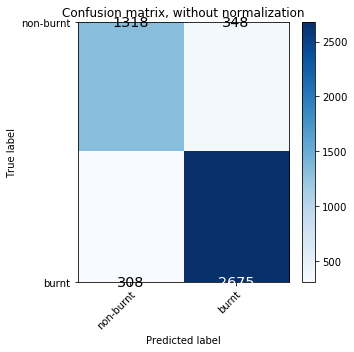

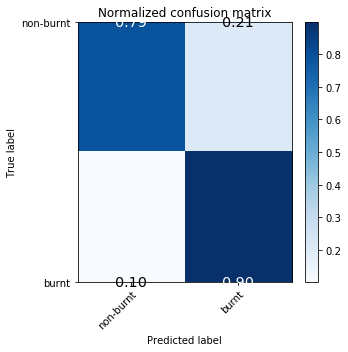

In [13]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [14]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1318, 348, 308, 2675)
	Accuracy = 85.89%
	Misclassification Rate = 14.11%
	Precision = 88.49%
	Recall = 89.67%
	F1-Score = 89.08%


## Logistic Regression

In [15]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
lr.score(X_test, y_test)

0.8337276833727684

Confusion matrix, without normalization
[[1112  554]
 [ 219 2764]]
Normalized confusion matrix
[[0.66746699 0.33253301]
 [0.07341602 0.92658398]]


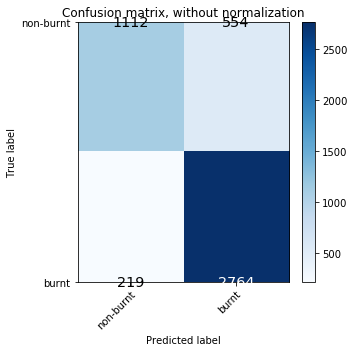

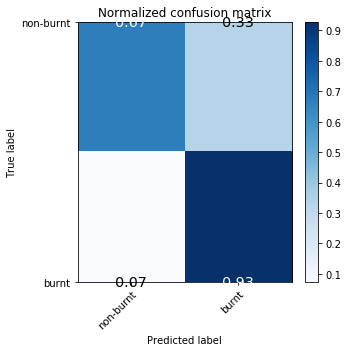

In [16]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [17]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1112, 554, 219, 2764)
	Accuracy = 83.37%
	Misclassification Rate = 16.63%
	Precision = 83.30%
	Recall = 92.66%
	F1-Score = 87.73%


## Naive Bayes

### Gaussian NB

In [18]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_predict = gnb.predict(X_test)
gnb.score(X_test, y_test)

0.8115723811572381

Confusion matrix, without normalization
[[1118  548]
 [ 328 2655]]
Normalized confusion matrix
[[0.67106843 0.32893157]
 [0.10995642 0.89004358]]


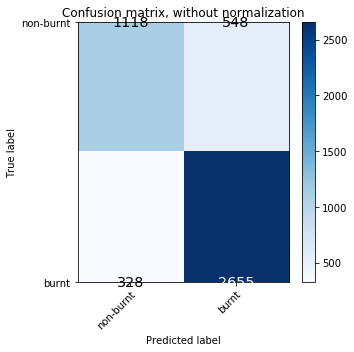

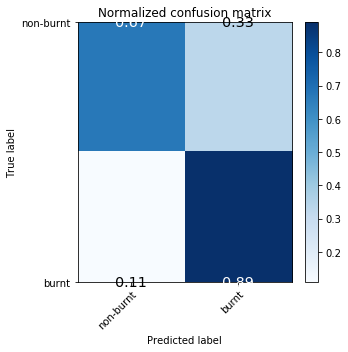

In [19]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [20]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1118, 548, 328, 2655)
	Accuracy = 81.16%
	Misclassification Rate = 18.84%
	Precision = 82.89%
	Recall = 89.00%
	F1-Score = 85.84%


### Bernoulli NB

In [21]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_predict = bnb.predict(X_test)
bnb.score(X_test, y_test)

0.7515594751559476

Confusion matrix, without normalization
[[ 729  937]
 [ 218 2765]]
Normalized confusion matrix
[[0.43757503 0.56242497]
 [0.07308079 0.92691921]]


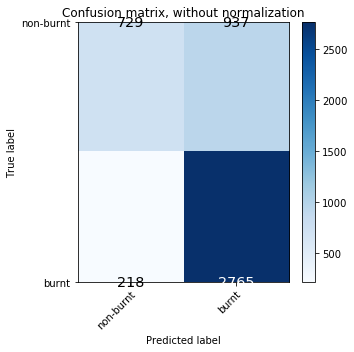

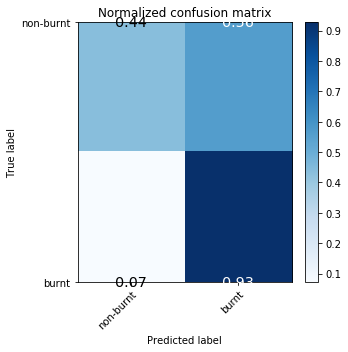

In [22]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [23]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (729, 937, 218, 2765)
	Accuracy = 75.16%
	Misclassification Rate = 24.84%
	Precision = 74.69%
	Recall = 92.69%
	F1-Score = 82.72%


## Stochastic Gradient Descent (SGD)

In [24]:
sgd = linear_model.SGDClassifier(random_state=38)
sgd.fit(X_train, y_train)
y_predict = sgd.predict(X_test)
sgd.score(X_test, y_test) #around 72-78%

C:\Users\ailin\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.7294041729404173

Confusion matrix, without normalization
[[1277  389]
 [ 869 2114]]
Normalized confusion matrix
[[0.7665066  0.2334934 ]
 [0.29131747 0.70868253]]


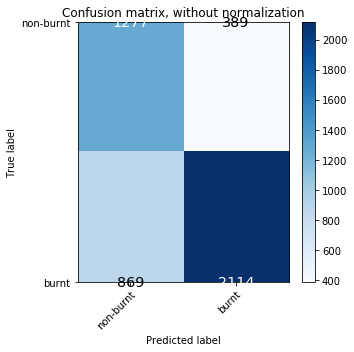

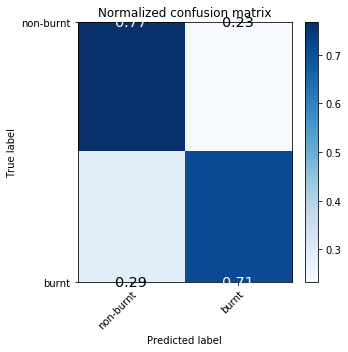

In [25]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [26]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1277, 389, 869, 2114)
	Accuracy = 72.94%
	Misclassification Rate = 27.06%
	Precision = 84.46%
	Recall = 70.87%
	F1-Score = 77.07%


## K-Nearest Neighbors

In [27]:
knn = KNeighborsClassifier() # n = 5
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
knn.score(X_test, y_test)

0.8352333835233383

Confusion matrix, without normalization
[[1193  473]
 [ 293 2690]]
Normalized confusion matrix
[[0.71608643 0.28391357]
 [0.09822327 0.90177673]]


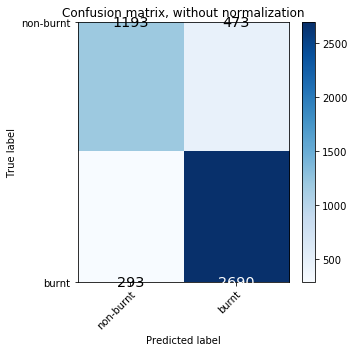

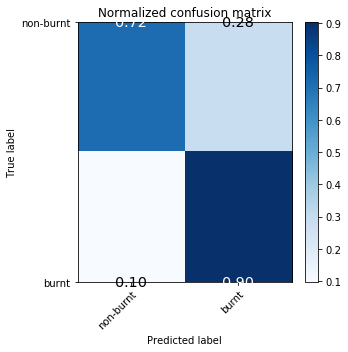

In [28]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [29]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1193, 473, 293, 2690)
	Accuracy = 83.52%
	Misclassification Rate = 16.48%
	Precision = 85.05%
	Recall = 90.18%
	F1-Score = 87.54%


## Decision Tree

In [30]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_predict = dtc.predict(X_test)
dtc.score(X_test, y_test)

0.804258980425898

Confusion matrix, without normalization
[[1196  470]
 [ 440 2543]]
Normalized confusion matrix
[[0.71788715 0.28211285]
 [0.14750251 0.85249749]]


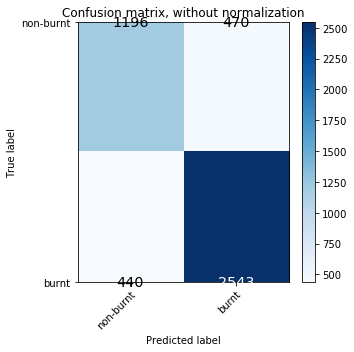

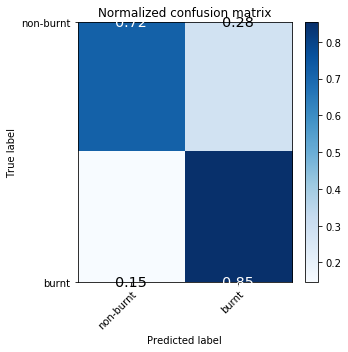

In [31]:
# Plot non-normalized confusion matrix
ax1 = plot_confusion_matrix(y_test, y_predict, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
ax2 = plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [32]:
print_scores(y_test, y_predict)

	(tn, fp, fn, tp) = (1196, 470, 440, 2543)
	Accuracy = 80.43%
	Misclassification Rate = 19.57%
	Precision = 84.40%
	Recall = 85.25%
	F1-Score = 84.82%


## SVM

In [33]:
#Support Vector Classifier
svc_lin = svm.SVC(kernel='linear')
svc_rbf = svm.SVC(kernel='rbf')
svc_poly = svm.SVC(kernel='poly')

svc_lin.fit(X_train, y_train)
svc_rbf.fit(X_train, y_train)
svc_poly.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [34]:
y_pred_l = svc_lin.predict(X_test)
y_pred_r = svc_rbf.predict(X_test)
y_pred_p = svc_poly.predict(X_test)

#### Results SVC linear kernel

In [36]:
print(confusion_matrix(y_test, y_pred_l))
print_scores(y_test, y_pred_l)

[[1081  585]
 [ 199 2784]]
	(tn, fp, fn, tp) = (1081, 585, 199, 2784)
	Accuracy = 83.14%
	Misclassification Rate = 16.86%
	Precision = 82.64%
	Recall = 93.33%
	F1-Score = 87.66%


#### Results SVC RBF kernel

In [38]:
print(confusion_matrix(y_test, y_pred_r))
print_scores(y_test, y_pred_r)

[[ 878  788]
 [ 173 2810]]
	(tn, fp, fn, tp) = (878, 788, 173, 2810)
	Accuracy = 79.33%
	Misclassification Rate = 20.67%
	Precision = 78.10%
	Recall = 94.20%
	F1-Score = 85.40%


#### Results SVC polynomial kernel

In [40]:
print(confusion_matrix(y_test, y_pred_p))
print_scores(y_test, y_pred_p)

[[1198  468]
 [ 238 2745]]
	(tn, fp, fn, tp) = (1198, 468, 238, 2745)
	Accuracy = 84.81%
	Misclassification Rate = 15.19%
	Precision = 85.43%
	Recall = 92.02%
	F1-Score = 88.61%
